In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


<img src='AdaBoost.jpg' alt="AdaBoost High Level">

<img src='AdaBoost_2.jpg' alt="AdaBoost High Level">

In [2]:
def stumpClassify(dataMat, dimen, threshVal, inEqualityType):
    retArray = np.ones((dataMat.shape[0], 1 ))
    
    if inEqualityType == 'lt':
        retArray[dataMat[:, dimen] <= threshVal] = -1.0
    else:
        retArray[dataMat[:, dimen] >  threshVal] =  -1.0

    #print(retArray)
    return retArray


In [3]:
def buildStump(dataMat, classLabels, D):
    dataMat = np.mat(dataMat)
    classLabelsMat = np.mat(classLabels).T
    
    m,n = dataMat.shape

    numSteps = 10
    bestStump = {}
    bestClassEst = np.mat(np.zeros((m,1)))
    minError = np.inf
    
    
    for i in range(n): # running for each column
        rangeMin = dataMat[:, i].min()
        rangeMax = dataMat[:, i].max()
        stepSize = (rangeMax - rangeMin) / numSteps
        
        for j in range(-1, int(numSteps)+1): # running 10 times for each column
            for inequal in ['lt', 'gt']:
                
                threshVal = (rangeMax + float(j) * stepSize)
                
                predictedVals = stumpClassify(dataMat, i, threshVal, inequal)
                
                errArr = np.mat(np.ones((m,1)))
                errArr[predictedVals == classLabelsMat] = 0
                
                weightedErr = np.dot(D.T ,errArr) # started with equal weights and now updating as per the error
                
                if weightedErr < minError:
                    minError = weightedErr
                    bestClassEst = predictedVals.copy()
                    bestStump['dim'] =  i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
                
    return bestStump, minError, bestClassEst



'''

dataMat = np.matrix([[ 1., 2.1],
                     [ 2. , 1.1],
                     [ 1.3 , 1. ],
                     [ 1. , 1. ],
                     [ 2. , 1. ]])

classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]


use_colours = {1: 'red', -1: 'green'}

bestStump, minError, bestClassEst = buildStump(dataMat, 
           classLabels, 
           np.mat(np.ones((dataMat.shape[0],1))/dataMat.shape[0]))



plt.subplot(1, 2, 1)
plt.scatter(dataMat[:,0].tolist(), dataMat[:, 1].tolist(), c = [use_colours[int(x)] for x in classLabels] , marker="*")
plt.title("Actual Data")

plt.subplot(1, 2, 2)
plt.scatter(dataMat[:,0].tolist(), dataMat[:, 1].tolist(), c = [use_colours[int(x)] for x in bestClassEst] )
plt.title("Classified data")
plt.show()
''';



<img src='AdaBoost Pseudocode.jpg' alt="AdaBoost Pseudocode">

In [4]:
def adaBoostTrainDS(dataMat, classLabels, numIt=40):
    weakClassArr = []
    m = dataMat.shape[0]
    weights = np.mat(np.ones((m, 1))/m)
    aggClassEst = np.mat(np.ones((m, 1)))
    
    for i in range(numIt):
    
        
        bestStump, error, classEst = buildStump(dataMat, 
                                                       classLabels, 
                                                       weights)
        alpha = float(0.5*np.log((1-error)/max(error, 1e-16)))
        
        bestStump['alpha'] = alpha
        weakClassArr.append(bestStump)
        
        new_weights = np.multiply(-1*alpha*np.mat(classLabels).T, classEst)

        # updating old weight according to the classification and misclassification
        weights = np.multiply(weights, np.exp(new_weights))
        weights = weights/weights.sum()
        # --
        
        # using runing sum of classEst --> exit conidition
        aggClassEst += alpha * classEst
        missclassification = sign(aggClassEst) != np.mat(classLabels).T
        
        # aggregating errors
        aggErrors = np.multiply(missclassification, np.ones((m,1)))
        errorRate = aggErrors.sum()/m
        
        print("Total error ={}".format(errorRate))
        if errorRate == 0.0:
            break
    return weakClassArr, aggClassEst


'''


dataMat = np.matrix([[ 1., 2.1],
                     [ 2. , 1.1],
                     [ 1.3 , 1. ],
                     [ 1. , 1. ],
                     [ 2. , 1. ]])

classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]


classifierArray = adaBoostTrainDS(dataMat, classLabels)
classifierArray



''';

In [5]:
def adaClassify(newData, classifierArray):
    
    dataMat = np.mat(newData)
    m = dataMat.shape[0]
    aggClassEst = np.mat(np.zeros((m,1)))
    
    for i in range(len(classifierArray)):
        
        classEst = stumpClassify(dataMat, 
                                 classifierArray[i]['dim'], 
                                 classifierArray[i]['thresh'], 
                                 classifierArray[i]['ineq'])
                         
        #print(classEst)
        aggClassEst += classifierArray[i]['alpha']*classEst
    return sign(aggClassEst)


'''

X_new = 1
Y_new = 1

use_colours = {1: 'red', -1: 'green'}


print("Classified as = {}".format(adaClassify([[X_new , Y_new]],classifierArray)))

dim = {0: "X", 1: "Y"}
for i in range(len(classifierArray)):
    value = classifierArray[i]['thresh']
    if dim[classifierArray[i]['dim']] == 'X':
        if (classifierArray[i]['ineq'] == 'lt'):
            plt.axvline(value, color='red')
        else:
            plt.axvline(value, color='yellow')
    else:
        if (classifierArray[i]['ineq'] == 'lt'):
            plt.axhline(value, color='red')
        else:
            plt.axhline(value, color='yellow')
        
    plt.scatter(dataMat[:,0].tolist(), dataMat[:, 1].tolist(), c = [use_colours[int(x)] for x in classLabels] , marker="*")
    plt.scatter(X_new, Y_new, marker="o", color = 'blue')






''';

In [6]:
data_HorseColic_Train = pd.read_csv('horseColicTraining2.txt', delimiter='\t', header=None)
datArr = data_HorseColic_Train.iloc[:,:-1]
labelArr = data_HorseColic_Train.iloc[:,-1]
classifierArray_HorseColic, aggClassEst  = adaBoostTrainDS(datArr,labelArr,70)


Total error =0.40468227424749165
Total error =0.40468227424749165
Total error =0.40468227424749165
Total error =0.40468227424749165
Total error =0.40468227424749165
Total error =0.40468227424749165
Total error =0.4013377926421405
Total error =0.39464882943143814
Total error =0.39464882943143814
Total error =0.39464882943143814
Total error =0.40468227424749165
Total error =0.3979933110367893
Total error =0.3979933110367893
Total error =0.39464882943143814
Total error =0.3979933110367893
Total error =0.39464882943143814
Total error =0.3979933110367893
Total error =0.39464882943143814
Total error =0.3979933110367893
Total error =0.39464882943143814
Total error =0.3979933110367893
Total error =0.3979933110367893
Total error =0.3979933110367893
Total error =0.3979933110367893
Total error =0.3979933110367893
Total error =0.3979933110367893
Total error =0.3979933110367893
Total error =0.3979933110367893
Total error =0.3979933110367893
Total error =0.3979933110367893
Total error =0.39799331103

In [7]:
data_HorseColic_Test = pd.read_csv('horseColicTest2.txt', delimiter='\t', header=None)
testArr = data_HorseColic_Test.iloc[:,:-1]

testLabelArr = data_HorseColic_Test.iloc[:,-1]
prediction = adaClassify(testArr,classifierArray_HorseColic)
errArr = np.mat(np.ones((testArr.shape[0],1)))

print("Total wrong prediction = {}, error % = {}".format(errArr[prediction != np.mat(testLabelArr).T].sum(), errArr[prediction != np.mat(testLabelArr).T].sum()/testArr.shape[0]))

Total wrong prediction = 21.0, error % = 0.31343283582089554


In [8]:
from sklearn.metrics import confusion_matrix
confusion_matrix(testLabelArr, prediction)

array([[11,  9],
       [12, 35]])

In [19]:
def plotROC(predStrengths, classLabels):
    import matplotlib.pyplot as plt
    
    cur = (1.0,1.0) #cursor
    ySum = 0.0 #variable to calculate AUC
    
    numPosClas = sum(array(classLabels)==1.0)
    
    yStep = 1/float(numPosClas)
    xStep = 1/float(len(classLabels)-numPosClas)
    
    sortedIndicies = predStrengths.argsort()#get sorted index, it's reverse
    
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    
    #loop through all the values, drawing a line segment at each point
    for index in sortedIndicies.tolist()[0]:
        if classLabels[index] == 1.0:
            delX = 0; delY = yStep;
        else:
            delX = xStep; delY = 0;
            ySum += cur[1]
        
        #draw line from cur to (cur[0]-delX,cur[1]-delY)
        ax.plot([cur[0],cur[0]-delX],[cur[1],cur[1]-delY], c='b')
        cur = (cur[0]-delX,cur[1]-delY)
    
    ax.plot([0,1],[0,1],'b--')
    plt.xlabel('False positive rate'); plt.ylabel('True positive rate')
    plt.title('ROC curve for AdaBoost horse colic detection system')
    ax.axis([0,1,0,1])
    plt.show()
    print("the Area Under the Curve is: ",ySum*xStep)



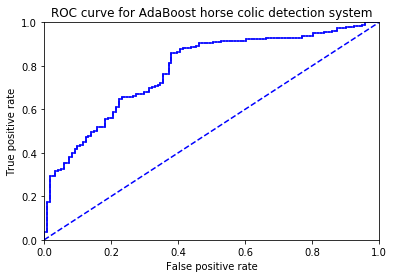

the Area Under the Curve is:  0.7804345807410152


In [20]:
plotROC(aggClassEst.T, labelArr )